
# Copyright Notice

The following code is based on the jupyter  [notebook](https://github.com/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb)

Author: [Matthew Carrigan](https://huggingface.co/Rocketknight1)


Please contact [me](mailto:d07b48002@ntu.edu.tw) if there is any questions about the copyright.

# Introduction

This is the HW6 of __人工智慧概論 / Introduction to Artificial Intelligence.__

This homework relies solely on Google Colab, enabling you to execute code entirely in the cloud without the need to concern yourself with setting up a local Python environment.


First, we will need to install 🤗 Transformers as well as some other libraries. Uncomment the following cell and run it.

In [2]:
!pip install transformers[torch] evaluate datasets requests pandas scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 583.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00


We will need to install Git-LFS which allow us to upload/download some large files
- checkpoints, model weights, etc.



In [3]:
!apt-get install git-lfs


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


To be able to share/save your model with the community, there are a few more steps to follow.


First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/) if you haven't already!).

How to get the code?
![How to get token](https://i.imgur.com/dwzMQou.png)

<!-- https://imgur.com/a/qNtJ2oK -->


__Then__ execute the following cell and input your username and password


In [4]:
from huggingface_hub import notebook_login

notebook_login()

# Fine-tuning Protein Language Modles.

We are going to do some __transfer learning__ to fine-tune some large, pre-trained protein language models on tasks of interest.

The specific model we're going to use is ESM-2, which is the state-of-the-art protein language model at the time of writing (November 2022). The citation for this model is [Lin et al, 2022](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1).

There are several ESM-2 checkpoints with differing model sizes. Larger models will generally have better accuracy, but they require more GPU memory and will take much longer to train. The available ESM-2 checkpoints (at time of writing) are:

| Checkpoint name | Num layers | Num parameters |
|------------------------------|----|----------|
| `esm2_t48_15B_UR50D`         | 48 | 15B     |
| `esm2_t36_3B_UR50D`          | 36 | 3B      |
| `esm2_t33_650M_UR50D`        | 33 | 650M    |
| `esm2_t30_150M_UR50D`        | 30 | 150M    |
| `esm2_t12_35M_UR50D`         | 12 | 35M     |
| `esm2_t6_8M_UR50D`           | 6  | 8M      |

Note that the larger checkpoints may be very difficult to train without a large cloud GPU like an A100 or H100, and the largest 15B parameter checkpoint will probably be impossible to train on **any** single GPU! Also, note that memory usage for attention during training will scale as `O(batch_size * num_layers * seq_len^2)`, so larger models on long sequences will use quite a lot of memory! We will use the `esm2_t12_35M_UR50D` checkpoint for this notebook, which should train on any Colab instance or modern GPU.

In [ ]:
model_checkpoint = "facebook/esm2_t12_35M_UR50D"

# Sequence classification

One of the most common tasks you can perform with a language model is **sequence classification**. In sequence classification, we classify an entire protein into a category, from a list of two or more possibilities. There's no limit on the number of categories you can use, or the specific problem you choose, as long as it's something the model could in theory infer from the raw protein sequence. To keep things simple for this example, though, let's try classifying proteins by their cellular localization - given their sequence, can we predict if they're going to be found in the cytosol (the fluid inside the cell) or embedded in the cell membrane?

## Data preparation

In this section, we're going to gather some training data from UniProt. Our goal is to create a pair of lists: `sequences` and `labels`. `sequences` will be a list of protein sequences, which will just be strings like "MNKL...", where each letter represents a single amino acid in the complete protein. `labels` will be a list of the category for each sequence. The categories will just be integers, with 0 representing the first category, 1 representing the second and so on. In other words, if `sequences[i]` is a protein sequence then `labels[i]` should be its corresponding category. These will form the **training data** we're going to use to teach the model the task we want it to do.


In [ ]:
import requests

query_url ="https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Csequence%2Ccc_subcellular_location&format=tsv&query=%28%28organism_id%3A9606%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28length%3A%5B80%20TO%20500%5D%29%29"

This query URL might seem mysterious, but it isn't! To get it, we searched for `(organism_id:9606) AND (reviewed:true) AND (length:[80 TO 500])` on UniProt to get a list of reasonably-sized human proteins,
then selected 'Download', and set the format to TSV and the columns to `Sequence` and `Subcellular location [CC]`, since those contain the data we care about for this task.

Once that's done, selecting `Generate URL for API` gives you a URL you can pass to Requests. Alternatively, if you're not on Colab you can just download the data through the web interface and open the file locally.

In [ ]:
uniprot_request = requests.get(query_url)

To get this data into Pandas, we use a `BytesIO` object, which Pandas will treat like a file. If you downloaded the data as a file you can skip this bit and just pass the filepath directly to `read_csv`.

In [ ]:
from io import BytesIO
import pandas

bio = BytesIO(uniprot_request.content)

df = pandas.read_csv(bio, compression='gzip', sep='\t')
df

,Entry,Sequence,Subcellular location [CC]
0,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...
1,A0AVI4,MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...,SUBCELLULAR LOCATION: Endoplasmic reticulum me...
2,A0JLT2,MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...,SUBCELLULAR LOCATION: Nucleus {ECO:0000305}.
3,A0M8Q6,GQPKAAPSVTLFPPSSEELQANKATLVCLVSDFNPGAVTVAWKADG...,SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...
4,A0PJY2,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...
...,...,...,...
11985,Q9HBI5,MTSLFAQEIRLSKRHEEIVSQRLMLLQQMENKLGDQHTEKASQLQT...,"SUBCELLULAR LOCATION: Cell projection, cilium ..."
11986,Q9NZ38,MAFPGQSDTKMQWPEVPALPLLSSLCMAMVRKSSALGKEVGRRSEG...,NaN
11987,Q9UFV3,MAETYRRSRQHEQLPGQRHMDLLTGYSKLIQSRLKLLLHLGSQPPV...,NaN
11988,Q9Y6C7,MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...,NaN


Nice! Now we have some proteins and their subcellular locations. Let's start filtering this down. First, let's ditch the columns without subcellular location information.

In [ ]:
df = df.dropna()  # Drop proteins with missing columns
df

,Entry,Sequence,Subcellular location [CC]
0,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...
1,A0AVI4,MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...,SUBCELLULAR LOCATION: Endoplasmic reticulum me...
2,A0JLT2,MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...,SUBCELLULAR LOCATION: Nucleus {ECO:0000305}.
3,A0M8Q6,GQPKAAPSVTLFPPSSEELQANKATLVCLVSDFNPGAVTVAWKADG...,SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...
4,A0PJY2,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...
...,...,...,...
11946,Q8WWF1,MDVLFVAIFAVPLILGQEYEDEERLGEDEYYQVVYYYTVTPSYDDF...,SUBCELLULAR LOCATION: Secreted {ECO:0000305}.
11967,Q96N68,MQGQGALKESHIHLPTEQPEASLVLQGQLAESSALGPKGALRPQAQ...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...
11974,Q9H0A3,MMNNTDFLMLNNPWNKLCLVSMDFCFPLDFVSNLFWIFASKFIIVT...,SUBCELLULAR LOCATION: Membrane {ECO:0000255}; ...
11977,Q9H354,MNKHNLRLVQLASELILIEIIPKLFLSQVTTISHIKREKIPPNHRK...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...


Now we'll make one dataframe of proteins that contain `cytosol` or `cytoplasm` in their subcellular localization column, and a second that mentions the `membrane` or `cell membrane`. To ensure we don't get overlap, we ensure each dataframe only contains proteins that don't match the other search term.

In [ ]:
cytosolic = df['Subcellular location [CC]'].str.contains("Cytosol") | df['Subcellular location [CC]'].str.contains("Cytoplasm")
membrane = df['Subcellular location [CC]'].str.contains("Membrane") | df['Subcellular location [CC]'].str.contains("Cell membrane")

In [ ]:
cytosolic_df = df[cytosolic & ~membrane]
cytosolic_df

,Entry,Sequence,Subcellular location [CC]
9,A1E959,MKIIILLGFLGATLSAPLIPQRLMSASNSNELLLNLNNGQLLPLQL...,SUBCELLULAR LOCATION: Secreted {ECO:0000250|Un...
14,A1XBS5,MMRRTLENRNAQTKQLQTAVSNVEKHFGELCQIFAAYVRKTARLRD...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...
18,A2RU49,MSSGNYQQSEALSKPTFSEEQASALVESVFGLKVSKVRPLPSYDDQ...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000305}.
20,A2RUH7,MEAATAPEVAAGSKLKVKEASPADAEPPQASPGQGAGSPTPQLLPP...,"SUBCELLULAR LOCATION: Cytoplasm, myofibril, sa..."
21,A4D126,MEAGPPGSARPAEPGPCLSGQRGADHTASASLQSVAGTEPGRHPQA...,"SUBCELLULAR LOCATION: Cytoplasm, cytosol {ECO:..."
...,...,...,...
11607,Q9BYD9,MNHCQLPVVIDNGSGMIKAGVAGCREPQFIYPNIIGRAKGQSRAAQ...,"SUBCELLULAR LOCATION: Cytoplasm, cytoskeleton ..."
11647,Q9NPB0,MEQRLAEFRAARKRAGLAAQPPAASQGAQTPGEKAEAAATLKAAPG...,SUBCELLULAR LOCATION: Cytoplasmic vesicle memb...
11659,Q9NUJ7,MGGQVSASNSFSRLHCRNANEDWMSALCPRLWDVPLHHLSIPGSHD...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...
11661,Q9NVM6,MAVTKELLQMDLYALLGIEEKAADKEVKKAYRQKALSCHPDKNPDN...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250|U...


In [ ]:
membrane_df = df[membrane & ~cytosolic]
membrane_df

,Entry,Sequence,Subcellular location [CC]
0,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...
3,A0M8Q6,GQPKAAPSVTLFPPSSEELQANKATLVCLVSDFNPGAVTVAWKADG...,SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...
17,A2RU14,MAGTVLGVGAGVFILALLWVAVLLLCVLLSRASGAARFSVIFLFFG...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...
33,A5X5Y0,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,SUBCELLULAR LOCATION: Postsynaptic cell membra...
36,A6ND01,MACWWPLLLELWTVMPTWAGDELLNICMNAKHHKRVPSPEDKLYEE...,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...
...,...,...,...
11901,Q86UQ5,MQSDIYHPGHSFPSWVLCWVHSCGHEGHLRETAEIRKTHQNGDLQI...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...
11927,Q8N8V8,MLLKVRRASLKPPATPHQGAFRAGNVIGQLIYLLTWSLFTAWLRPP...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...
11967,Q96N68,MQGQGALKESHIHLPTEQPEASLVLQGQLAESSALGPKGALRPQAQ...,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...
11974,Q9H0A3,MMNNTDFLMLNNPWNKLCLVSMDFCFPLDFVSNLFWIFASKFIIVT...,SUBCELLULAR LOCATION: Membrane {ECO:0000255}; ...


We're almost done! Now, let's make a list of sequences from each df and generate the associated labels. We'll use `0` as the label for cytosolic proteins and `1` as the label for membrane proteins.

In [ ]:
cytosolic_sequences = cytosolic_df["Sequence"].tolist()
cytosolic_labels = [0 for protein in cytosolic_sequences]


In [ ]:
membrane_sequences = membrane_df["Sequence"].tolist()
membrane_labels = [1 for protein in membrane_sequences]

Now we can concatenate these lists together to get the `sequences` and `labels` lists that will form our final training data. Don't worry - they'll get shuffled during training!

In [ ]:
sequences = cytosolic_sequences + membrane_sequences
labels = cytosolic_labels + membrane_labels

# Quick check to make sure we got it right
len(sequences) == len(labels)

True

All done, next we need to prepare the data for training.

## Splitting the data


Since the data we're loading isn't prepared for us as a machine learning dataset, we'll have to split the data into train and test sets ourselves! We can use sklearn's function for that:

In [ ]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=True)

Let's check out what does the splited data look like.

In [ ]:
print(len(train_sequences))
print(len(train_labels))
print(train_sequences[0])
print(train_labels[0])

3842
3842
MVFAHRMDNSKPHLIIPTLLVPLQNRSCTETATPLPSQYLMELSEEHSWMSNQTDLHYVLKPGEVATASIFFGILWLFSIFGNSLVCLVIHRSRRTQSTTNYFVVSMACADLLISVASTPFVLLQFTTGRWTLGSATCKVVRYFQYLTPGVQIYVLLSICIDRFYTIVYPLSFKVSREKAKKMIAASWVFDAGFVTPVLFFYGSNWDSHCNYFLPSSWEGTAYTVIHFLVGFVIPSVLIILFYQKVIKYIWRIGTDGRTVRRTMNIVPRTKVKTIKMFLILNLLFLLSWLPFHVAQLWHPHEQDYKKSSLVFTAITWISFSSSASKPTLYSIYNANFRRGMKETFCMSSMKCYRSNAYTITTSSRMAKKNYVGISEIPSMAKTITKDSIYDSFDREAKEKKLAWPINSNPPNTFV
1


## Tokenizing the data

All inputs to neural nets must be numerical. The process of converting strings into numerical indices suitable for a neural net is called **tokenization**. For natural language this can be quite complex, as usually the network's vocabulary will not contain every possible word, which means the tokenizer must handle splitting rarer words into pieces, as well as all the complexities of capitalization and unicode characters and so on.

With proteins, however, things are very easy. In protein language models, each amino acid is converted to a single token. Every model on `transformers` comes with an associated `tokenizer` that handles tokenization for it, and protein language models are no different. Let's get our tokenizer!

In [9]:
from transformers import AutoTokenizer
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) # model_checkpoint = "facebook/esm2_t12_35M_UR50D"

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's try to feed a prortein sequences into tokenizer to see what it generated.

In [ ]:
# train_sequences[0]
tokenizer(train_sequences[1])

{'input_ids': [0, 20, 5, 6, 15, 7, 10, 8, 4, 4, 14, 14, 4, 4, 4, 5, 5, 5, 6, 4, 5, 6, 4, 4, 4, 4, 23, 7, 14, 11, 10, 13, 7, 10, 9, 14, 14, 5, 4, 15, 19, 6, 12, 7, 4, 13, 5, 6, 8, 8, 21, 11, 8, 20, 18, 12, 19, 15, 22, 14, 5, 13, 15, 9, 17, 13, 11, 6, 12, 7, 6, 16, 21, 8, 8, 23, 13, 7, 14, 6, 6, 6, 12, 8, 8, 19, 5, 13, 17, 14, 8, 6, 5, 8, 16, 8, 4, 7, 6, 23, 4, 9, 16, 5, 4, 16, 13, 7, 14, 15, 9, 10, 21, 5, 6, 11, 14, 4, 19, 4, 6, 5, 11, 5, 6, 20, 10, 4, 4, 17, 4, 11, 17, 14, 9, 5, 8, 11, 8, 7, 4, 20, 5, 7, 11, 21, 11, 4, 11, 16, 19, 14, 18, 13, 18, 10, 6, 5, 10, 12, 4, 8, 6, 16, 9, 9, 6, 7, 18, 6, 22, 7, 11, 5, 17, 19, 4, 4, 9, 17, 18, 12, 15, 19, 6, 22, 7, 6, 10, 22, 18, 10, 14, 10, 15, 6, 11, 4, 6, 5, 20, 13, 4, 6, 6, 5, 8, 11, 16, 12, 11, 18, 9, 11, 11, 8, 14, 5, 9, 13, 10, 5, 8, 9, 7, 16, 4, 21, 4, 19, 6, 16, 21, 19, 10, 7, 19, 11, 21, 8, 18, 4, 23, 19, 6, 10, 13, 16, 7, 4, 16, 10, 4, 4, 5, 8, 5, 4, 16, 11, 21, 6, 18, 21, 14, 23, 22, 14, 10, 6, 18, 8, 11, 16, 7, 4, 4, 6, 13, 7, 19, 1

This looks good! We can see that our sequence has been converted into `input_ids`, which is the tokenized sequence, and an `attention_mask`. The attention mask handles the case when we have sequences of variable length - in those cases, the shorter sequences are padded with blank "padding" tokens, and the attention mask is padded with 0s to indicate that those tokens should be ignored by the model.

So now, let's tokenize our whole dataset. Note that we don't need to do anything with the labels, as they're already in the format we need.

In [ ]:
train_tokenized = tokenizer(train_sequences)
test_tokenized = tokenizer(test_sequences)

## Dataset creation

Now we want to turn this data into a dataset that PyTorch can load samples from. We can use the HuggingFace `Dataset` class for this, although if you prefer you can also use `torch.utils.data.Dataset`, at the cost of some more boilerplate code.

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 3842
})

This looks good, but we're missing our labels! Let's add those on as an extra column to the datasets.

In [ ]:
train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3842
})

Looks good! We're ready for training.

## Model loading

Next, we want to load our model. Make sure to use exactly the same model as you used when loading the tokenizer, or your model might not understand the tokenization scheme you're using!

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


These warnings are telling us that the model is discarding some weights that it used for language modelling (the `lm_head`) and adding some weights for sequence classification (the `classifier`). This is exactly what we expect when we want to fine-tune a language model on a sequence classification task!

Next, we initialize our `TrainingArguments`. These control the various training hyperparameters, and will be passed to our `Trainer`.

In [ ]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization",
    evaluation_strategy = "epoch", #"steps", eval_steps=200,
    save_strategy = "epoch", #"steps", save_steps=200,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Next, we define the metric we will use to evaluate our models and write a `compute_metrics` function. We can load this from the `evaluate` library.

In [ ]:
from evaluate import load
from evaluate import combine
import numpy as np

clf_metrics = combine(["accuracy", "f1", "precision", "recall"])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return clf_metrics.compute(predictions=predictions, references=labels)




And at last we're ready to initialize our `Trainer`:

In [ ]:
trainer_finetuned = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it one last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer_finetuned.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.148343,0.957065,0.955248,0.963875,0.946774
2,0.242800,0.147870,0.958626,0.957154,0.959481,0.954839
3,0.156900,0.149324,0.958626,0.957015,0.962480,0.951613


TrainOutput(global_step=1443, training_loss=0.17085862242341124, metrics={'train_runtime': 701.6436, 'train_samples_per_second': 16.427, 'train_steps_per_second': 2.057, 'total_flos': 1035250349914188.0, 'train_loss': 0.17085862242341124, 'epoch': 3.0})

Nice! After three epochs we have a model accuracy of ~94%. Note that we didn't do a lot of work to filter the training data or tune hyperparameters for this experiment, and also that we used one of the smallest ESM-2 models. With a larger starting model and more effort to ensure that the training data categories were cleanly separable, accuracy could almost certainly go a lot higher!

In [ ]:
trainer_finetuned.evaluate(train_dataset)

{'eval_loss': 0.11264257878065109,
 'eval_accuracy': 0.9643414888079126,
 'eval_f1': 0.9645720196534782,
 'eval_precision': 0.9638242894056848,
 'eval_recall': 0.9653209109730849,
 'eval_runtime': 75.6397,
 'eval_samples_per_second': 50.793,
 'eval_steps_per_second': 6.359,
 'epoch': 3.0}

In [ ]:
trainer_finetuned.evaluate(test_dataset)

{'eval_loss': 0.14787036180496216,
 'eval_accuracy': 0.9586260733801717,
 'eval_f1': 0.9571544058205336,
 'eval_precision': 0.9594813614262561,
 'eval_recall': 0.9548387096774194,
 'eval_runtime': 25.7286,
 'eval_samples_per_second': 49.789,
 'eval_steps_per_second': 6.258,
 'epoch': 3.0}

##TODO #1 Completed !


In [ ]:
# 2. Train the model loaded by the config here
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a labelconfig = AutoConfig.from_pretrained(model_checkpoint)

model_checkpoint = "facebook/esm2_t12_35M_UR50D"
config = AutoConfig.from_pretrained(model_checkpoint)
print(num_labels)
model = AutoModelForSequenceClassification.from_config(config)

2


In [ ]:
trainer_config = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_config.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.405198,0.848556,0.832759,0.894444,0.779032
2,0.420700,0.372331,0.861827,0.856448,0.861338,0.851613
3,0.378900,0.351292,0.867291,0.860656,0.875000,0.846774


TrainOutput(global_step=1443, training_loss=0.3861420671723406, metrics={'train_runtime': 714.2794, 'train_samples_per_second': 16.137, 'train_steps_per_second': 2.02, 'total_flos': 1035250349914188.0, 'train_loss': 0.3861420671723406, 'epoch': 3.0})

In [ ]:
trainer_config.evaluate(train_dataset)

{'eval_loss': 0.34194737672805786,
 'eval_accuracy': 0.8669963560645497,
 'eval_f1': 0.8648505686326369,
 'eval_precision': 0.8842617631151974,
 'eval_recall': 0.8462732919254659,
 'eval_runtime': 77.6354,
 'eval_samples_per_second': 49.488,
 'eval_steps_per_second': 6.196,
 'epoch': 3.0}

In [ ]:
trainer_config.evaluate(test_dataset)

{'eval_loss': 0.35129228234291077,
 'eval_accuracy': 0.8672911787665886,
 'eval_f1': 0.8606557377049181,
 'eval_precision': 0.875,
 'eval_recall': 0.8467741935483871,
 'eval_runtime': 25.3175,
 'eval_samples_per_second': 50.597,
 'eval_steps_per_second': 6.359,
 'epoch': 3.0}

In [ ]:
# 3. Evaluate the pretrained model without finetuned here (trainer_pretrained)
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_pretrained = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_pretrained.evaluate(train_dataset)

{'eval_loss': 0.7060719728469849,
 'eval_accuracy': 0.5028630921395106,
 'eval_f1': 0.6692067890543816,
 'eval_precision': 0.5028630921395106,
 'eval_recall': 1.0,
 'eval_runtime': 76.0195,
 'eval_samples_per_second': 50.54,
 'eval_steps_per_second': 6.327}

In [ ]:
trainer_pretrained.evaluate(test_dataset)

{'eval_loss': 0.7105633616447449,
 'eval_accuracy': 0.4839968774395004,
 'eval_f1': 0.6522882693319305,
 'eval_precision': 0.4839968774395004,
 'eval_recall': 1.0,
 'eval_runtime': 25.1926,
 'eval_samples_per_second': 50.848,
 'eval_steps_per_second': 6.391}

##TODO #2 Results

1. finetuned - train acc: 0.964 / test acc: 0.959
2. config - train acc: 0.867 / test acc: 0.867
3. pretrained - train acc: 0.503 / test acc: 0.484

Accuracy Ranking: 1 > 2 > 3

## Load Different Dataset


In [5]:
from datasets import load_dataset

base_url = "https://raw.githubusercontent.com/nadavbra/protein_bert/master/protein_benchmarks/"

hw_dataset = load_dataset('csv', data_files ={'train': base_url +'scop.train.csv', "test": base_url + "scop.test.csv"})

# hw_dataset = hw_dataset.rename_column('seq', 'input_id')

hw_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['seq', 'label'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['seq', 'label'],
        num_rows: 3921
    })
})

In [6]:
from collections import Counter
element_counts = Counter(hw_dataset['train']['label'])

for element, count in element_counts.items():
    print(f"{element}: {count}")

# hw_dataset['train']['label'].value_count()

c: 4663
d: 3734
b: 3290
g: 869
a: 2616
e: 290
f: 218


In [7]:
import pandas as pd
df_hw_train = pd.DataFrame(hw_dataset['train'])
df_hw_test = pd.DataFrame(hw_dataset['test'])
combined_df = pd.concat([df_hw_train, df_hw_test], axis=0)

vc_all = combined_df['label'].value_counts()
vc_train = df_hw_train["label"].value_counts()
vc_test = df_hw_test["label"].value_counts()

In [16]:
hw_train_dataset = hw_dataset['train']
hw_test_dataset =  hw_dataset['test']

hw_train_dataset = hw_train_dataset.map(lambda e: tokenizer(e['seq'], padding=True, truncation=True))
hw_test_dataset = hw_test_dataset.map(lambda e: tokenizer(e['seq'], padding=True, truncation=True))

def encode(e):
  e["label"] = {'a': 0,'b': 1,'c': 2,'d': 3,'e': 4,'f': 5,'g': 6}[e["label"]]
  return e

hw_train_dataset = hw_train_dataset.map(encode)
hw_test_dataset = hw_test_dataset.map(encode)

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/3921 [00:00<?, ? examples/s]

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/3921 [00:00<?, ? examples/s]

## TODO 3 Result

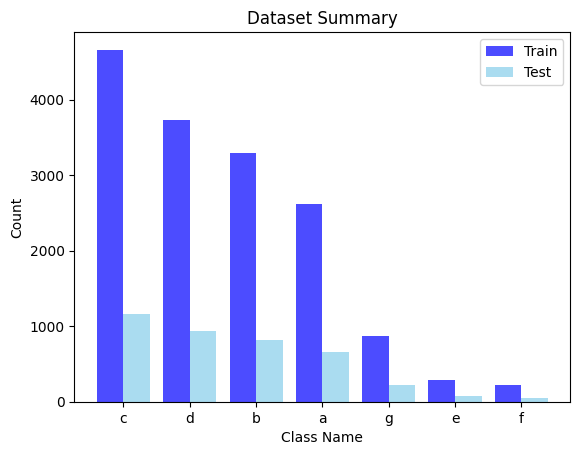

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
categories = pd.Index(vc_train.index.union(vc_test.index))

# Plot the bar chart with adjusted positions
X_axis = np.arange(len(categories))
plt.bar(X_axis - 0.2, vc_train, 0.4, color='blue', label='Train', alpha=0.7)
plt.bar(X_axis + 0.2, vc_test, 0.4, color='skyblue', label='Test', alpha=0.7)

# Customize the plot
plt.title('Dataset Summary')
plt.xlabel('Class Name')
plt.xticks(X_axis, categories)
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()

In [10]:
from transformers import AutoTokenizer
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=7)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization-SCOP",
    evaluation_strategy = "epoch", #"steps", eval_steps=200,
    save_strategy = "epoch", #"steps", save_steps=200,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [9]:
from evaluate import load
from evaluate import combine
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    class_f1_scores = {}
    for class_id in np.unique(labels):
        class_labels = labels == class_id
        class_predictions = predictions == class_id

        class_f1 = f1_score(class_labels, class_predictions)
        class_f1_scores[f'class_{class_id}_f1'] = class_f1
    print(class_f1_scores)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=1)  # Set zero_division to 1 or another suitable value


    return {
        'accuracy': accuracy,
        'f1': f1
    }


In [ ]:
hw_trainer_finetuned = Trainer(
    model,
    args,
    train_dataset=hw_train_dataset,
    eval_dataset=hw_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
hw_trainer_finetuned.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.312600,0.234932,0.940321,0.939467
2,0.182100,0.230011,0.943127,0.942731
3,0.104100,0.236640,0.948738,0.948573


{'class_0_f1': 0.9488372093023256, 'class_1_f1': 0.9456322541233965, 'class_2_f1': 0.9757155247181265, 'class_3_f1': 0.9013224821973551, 'class_4_f1': 0.6481481481481481, 'class_5_f1': 0.8712871287128713, 'class_6_f1': 0.9723502304147466}
{'class_0_f1': 0.9435069699192957, 'class_1_f1': 0.9445114595898674, 'class_2_f1': 0.9784110535405872, 'class_3_f1': 0.9040043883708173, 'class_4_f1': 0.7851851851851852, 'class_5_f1': 0.9074074074074073, 'class_6_f1': 0.9703872437357631}
{'class_0_f1': 0.9562594268476622, 'class_1_f1': 0.9478847332924586, 'class_2_f1': 0.9806451612903225, 'class_3_f1': 0.912187333688132, 'class_4_f1': 0.8, 'class_5_f1': 0.9158878504672897, 'class_6_f1': 0.9703872437357631}


TrainOutput(global_step=5880, training_loss=0.26634531669876205, metrics={'train_runtime': 2027.0002, 'train_samples_per_second': 23.207, 'train_steps_per_second': 2.901, 'total_flos': 3225921037809792.0, 'train_loss': 0.26634531669876205, 'epoch': 3.0})

In [ ]:
hw_trainer_finetuned.evaluate(hw_train_dataset)

{'class_0_f1': 0.9814323607427057, 'class_1_f1': 0.9887366818873667, 'class_2_f1': 0.9915062896462747, 'class_3_f1': 0.9783042725941701, 'class_4_f1': 0.8722627737226277, 'class_5_f1': 0.9216152019002376, 'class_6_f1': 0.9866975130133024}


{'eval_loss': 0.07119906693696976,
 'eval_accuracy': 0.982780612244898,
 'eval_f1': 0.982656962933797,
 'eval_runtime': 225.863,
 'eval_samples_per_second': 69.423,
 'eval_steps_per_second': 8.678,
 'epoch': 3.0}

In [ ]:
hw_trainer_finetuned.evaluate(hw_test_dataset)

{'class_0_f1': 0.9562594268476622, 'class_1_f1': 0.9478847332924586, 'class_2_f1': 0.9806451612903225, 'class_3_f1': 0.912187333688132, 'class_4_f1': 0.8, 'class_5_f1': 0.9158878504672897, 'class_6_f1': 0.9703872437357631}


{'eval_loss': 0.2366403192281723,
 'eval_accuracy': 0.9487375669472073,
 'eval_f1': 0.948572737750566,
 'eval_runtime': 58.3816,
 'eval_samples_per_second': 67.162,
 'eval_steps_per_second': 8.41,
 'epoch': 3.0}

## TODO #4

F1-score of each class:
**{'class_0_f1': 0.9562594268476622, 'class_1_f1': 0.9478847332924586, 'class_2_f1': 0.9806451612903225, 'class_3_f1': 0.912187333688132, 'class_4_f1': 0.8, 'class_5_f1': 0.9158878504672897, 'class_6_f1': 0.9703872437357631}**


Use weighted F1-score for our multi-class task (due to data imbalance)
**weighted-F1: 0.948**


## TODO #5 : Try with different epochs

In [11]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization-SCOP",
    evaluation_strategy = "epoch", #"steps", eval_steps=200,
    save_strategy = "epoch", #"steps", save_steps=200,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [12]:
hw_trainer_finetuned = Trainer(
    model,
    args,
    train_dataset=hw_train_dataset,
    eval_dataset=hw_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
hw_trainer_finetuned.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.287000,0.259954,0.926804,0.926645
2,0.181000,0.258998,0.940576,0.939993
3,0.105600,0.246842,0.949248,0.948854
4,0.061200,0.333682,0.948738,0.948255
5,0.036300,0.326942,0.952308,0.952262
6,0.026300,0.327636,0.952563,0.952494
7,0.014000,0.361369,0.954858,0.955005
8,0.002400,0.356871,0.953073,0.953167
9,0.003900,0.368554,0.954858,0.954857
10,0.000100,0.370357,0.956134,0.956192


{'class_0_f1': 0.930756843800322, 'class_1_f1': 0.9411057692307692, 'class_2_f1': 0.9674295774647889, 'class_3_f1': 0.8790443006470882, 'class_4_f1': 0.6194690265486725, 'class_5_f1': 0.8846153846153846, 'class_6_f1': 0.958904109589041}
{'class_0_f1': 0.9342960288808664, 'class_1_f1': 0.942501481920569, 'class_2_f1': 0.9783362218370883, 'class_3_f1': 0.9062500000000001, 'class_4_f1': 0.732824427480916, 'class_5_f1': 0.8952380952380952, 'class_6_f1': 0.967741935483871}
{'class_0_f1': 0.9530408006158583, 'class_1_f1': 0.9494584837545126, 'class_2_f1': 0.9815371404036067, 'class_3_f1': 0.9167108753315649, 'class_4_f1': 0.7903225806451611, 'class_5_f1': 0.9038461538461537, 'class_6_f1': 0.9612756264236902}
{'class_0_f1': 0.9509658246656761, 'class_1_f1': 0.9492354740061163, 'class_2_f1': 0.9831387808041504, 'class_3_f1': 0.9161358811040339, 'class_4_f1': 0.7666666666666666, 'class_5_f1': 0.9142857142857144, 'class_6_f1': 0.9567198177676537}
{'class_0_f1': 0.9593984962406015, 'class_1_f1': 

TrainOutput(global_step=19600, training_loss=0.0894572911117397, metrics={'train_runtime': 7174.6852, 'train_samples_per_second': 21.855, 'train_steps_per_second': 2.732, 'total_flos': 1.0766903051427456e+16, 'train_loss': 0.0894572911117397, 'epoch': 10.0})

In [ ]:
hw_trainer_finetuned.evaluate(hw_train_dataset)

In [ ]:
hw_trainer_finetuned.evaluate(hw_test_dataset)

{'class_0_f1': 0.9549274255156608, 'class_1_f1': 0.9577981651376147, 'class_2_f1': 0.984920292977165, 'class_3_f1': 0.926338102808691, 'class_4_f1': 0.8732394366197183, 'class_5_f1': 0.9074074074074073, 'class_6_f1': 0.9681818181818181}


{'eval_loss': 0.3703565001487732,
 'eval_accuracy': 0.9561336393777098,
 'eval_f1': 0.9561923689246324,
 'eval_runtime': 62.3916,
 'eval_samples_per_second': 62.845,
 'eval_steps_per_second': 7.87,
 'epoch': 10.0}

## TODO #6-1 : Try with different learning rate

In [13]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization-SCOP",
    evaluation_strategy = "epoch", #"steps", eval_steps=200,
    save_strategy = "epoch", #"steps", save_steps=200,
    learning_rate=2e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [18]:
hw_trainer_finetuned = Trainer(
    model,
    args,
    train_dataset=hw_train_dataset,
    eval_dataset=hw_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
hw_trainer_finetuned.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.208000,0.989953,0.786534,0.767158
2,0.764000,0.691888,0.869931,0.855582
3,0.616700,0.618728,0.877582,0.863276


{'class_0_f1': 0.7921117502054231, 'class_1_f1': 0.7835159102764738, 'class_2_f1': 0.9049180327868852, 'class_3_f1': 0.7272727272727272, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.5136986301369864}
{'class_0_f1': 0.881704628949302, 'class_1_f1': 0.8823880597014926, 'class_2_f1': 0.9435723377174373, 'class_3_f1': 0.8164556962025317, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.8752941176470588}
{'class_0_f1': 0.8906942392909897, 'class_1_f1': 0.8919402985074627, 'class_2_f1': 0.9492537313432836, 'class_3_f1': 0.8214285714285715, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.8990825688073395}


TrainOutput(global_step=5880, training_loss=0.9388773133154629, metrics={'train_runtime': 2052.8693, 'train_samples_per_second': 22.914, 'train_steps_per_second': 2.864, 'total_flos': 3225921037809792.0, 'train_loss': 0.9388773133154629, 'epoch': 3.0})

In [20]:
hw_trainer_finetuned.evaluate(hw_train_dataset)

{'class_0_f1': 0.8997071742313324, 'class_1_f1': 0.8897849462365591, 'class_2_f1': 0.9507426007052036, 'class_3_f1': 0.8288854003139716, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.8999407933688574}


{'eval_loss': 0.6049222946166992,
 'eval_accuracy': 0.8809948979591836,
 'eval_f1': 0.8668013917223034,
 'eval_runtime': 230.7314,
 'eval_samples_per_second': 67.958,
 'eval_steps_per_second': 8.495,
 'epoch': 3.0}

In [21]:
hw_trainer_finetuned.evaluate(hw_test_dataset)

{'class_0_f1': 0.8906942392909897, 'class_1_f1': 0.8919402985074627, 'class_2_f1': 0.9492537313432836, 'class_3_f1': 0.8214285714285715, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.8990825688073395}


{'eval_loss': 0.6187281608581543,
 'eval_accuracy': 0.8775822494261668,
 'eval_f1': 0.8632758284846386,
 'eval_runtime': 57.4918,
 'eval_samples_per_second': 68.201,
 'eval_steps_per_second': 8.54,
 'epoch': 3.0}

## TODO #6-2 : Try with a lighter model

In [22]:
from transformers import AutoTokenizer
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=7)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization-SCOP",
    evaluation_strategy = "epoch", #"steps", eval_steps=200,
    save_strategy = "epoch", #"steps", save_steps=200,
    learning_rate=2e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [24]:
hw_trainer_finetuned = Trainer(
    model,
    args,
    train_dataset=hw_train_dataset,
    eval_dataset=hw_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [25]:
hw_trainer_finetuned.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.415800,1.252996,0.750319,0.732240
2,1.056800,1.006487,0.799796,0.784513
3,0.932200,0.938058,0.806937,0.792027


{'class_0_f1': 0.8183229813664596, 'class_1_f1': 0.7760506620610247, 'class_2_f1': 0.8408916218293622, 'class_3_f1': 0.5876229034123771, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.7765363128491619}
{'class_0_f1': 0.8628912071535023, 'class_1_f1': 0.8154205607476636, 'class_2_f1': 0.8898931799506985, 'class_3_f1': 0.6530837004405288, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.8926829268292683}
{'class_0_f1': 0.8677563150074294, 'class_1_f1': 0.8196721311475411, 'class_2_f1': 0.8956953642384106, 'class_3_f1': 0.6677595628415302, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.9033816425120773}


TrainOutput(global_step=5880, training_loss=1.1959452778303705, metrics={'train_runtime': 712.2633, 'train_samples_per_second': 66.043, 'train_steps_per_second': 8.255, 'total_flos': 722817482053632.0, 'train_loss': 1.1959452778303705, 'epoch': 3.0})

In [26]:
hw_trainer_finetuned.evaluate(hw_train_dataset)

{'class_0_f1': 0.8555718475073314, 'class_1_f1': 0.8319535221496006, 'class_2_f1': 0.9007299270072993, 'class_3_f1': 0.6998904709748083, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.8744588744588745}


{'eval_loss': 0.9249752163887024,
 'eval_accuracy': 0.8150510204081632,
 'eval_f1': 0.8002999024943301,
 'eval_runtime': 82.8449,
 'eval_samples_per_second': 189.269,
 'eval_steps_per_second': 23.659,
 'epoch': 3.0}

In [27]:
hw_trainer_finetuned.evaluate(hw_test_dataset)

{'class_0_f1': 0.8677563150074294, 'class_1_f1': 0.8196721311475411, 'class_2_f1': 0.8956953642384106, 'class_3_f1': 0.6677595628415302, 'class_4_f1': 0.0, 'class_5_f1': 0.0, 'class_6_f1': 0.9033816425120773}


{'eval_loss': 0.9380576014518738,
 'eval_accuracy': 0.8069370058658506,
 'eval_f1': 0.7920267985737159,
 'eval_runtime': 24.7322,
 'eval_samples_per_second': 158.538,
 'eval_steps_per_second': 19.853,
 'epoch': 3.0}

## TODO #5 6 Result
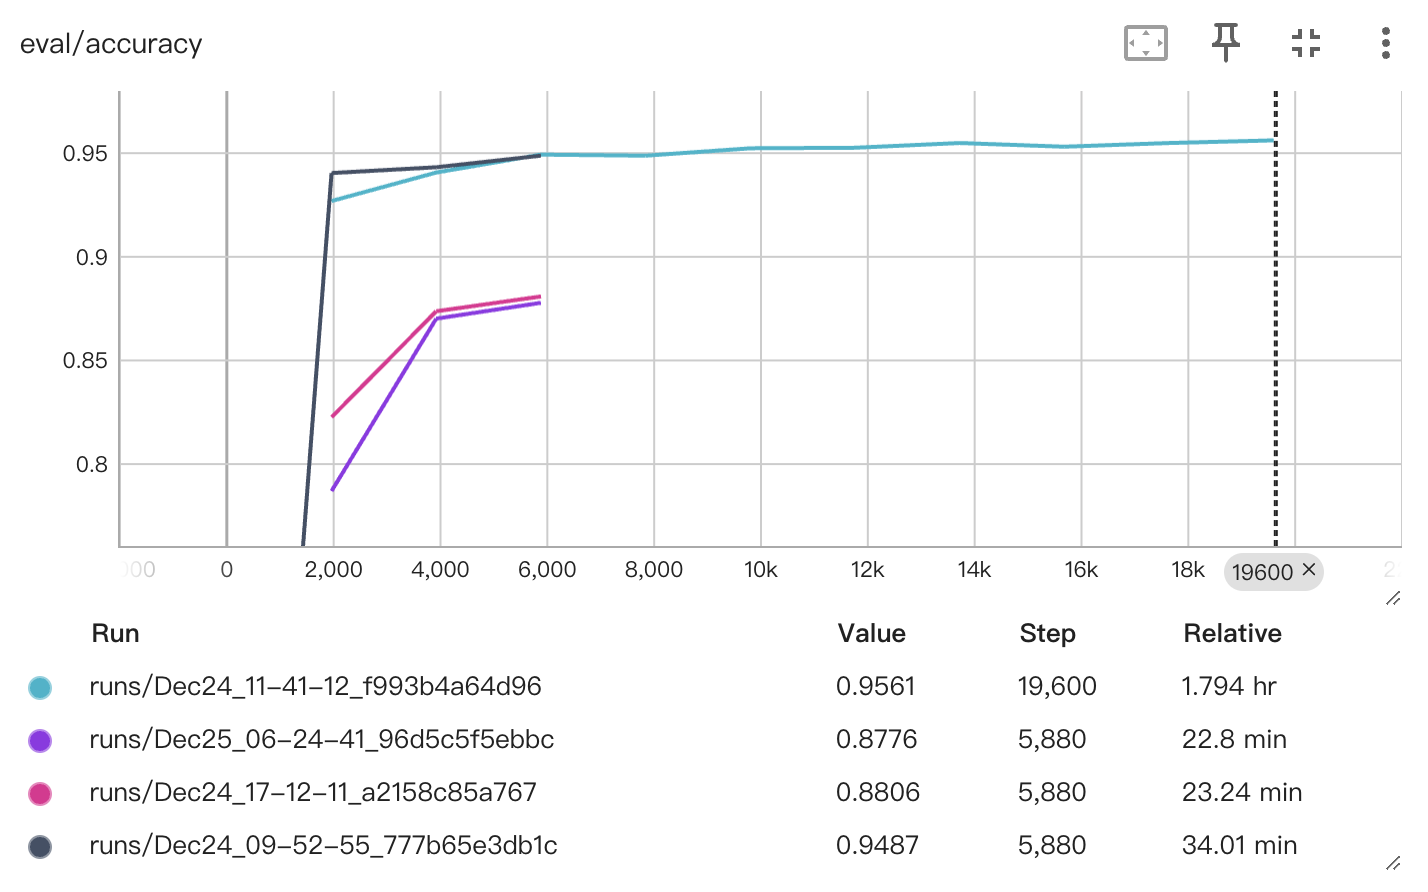

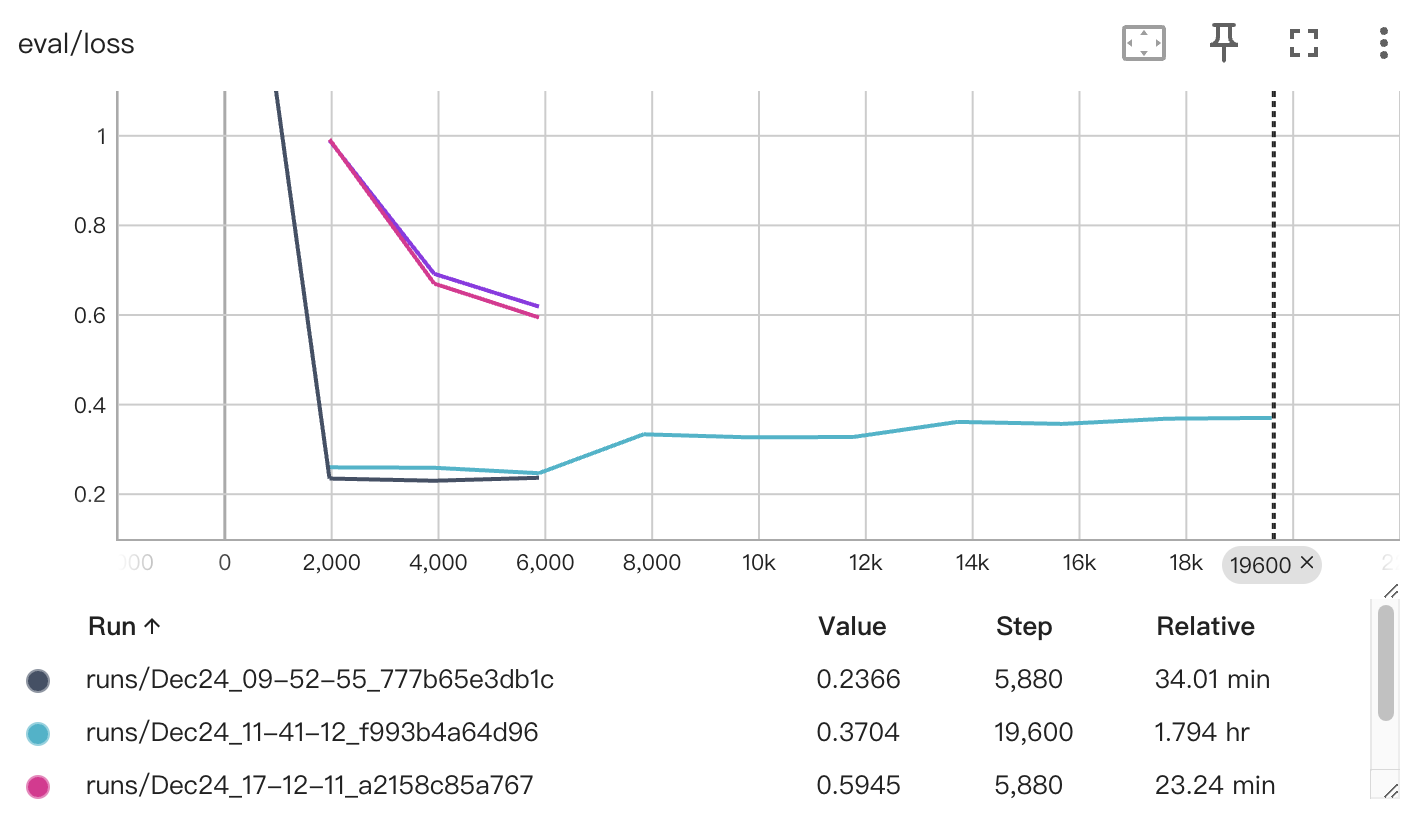

+ Cyan: epoch=10
+ Dark: original (epoch=3, lr=2e-5)
+ Magenta: lr=2e-6
+ Purple: light model (esm2_t6_8M_UR50D)

I attempted to train more epochs (3 to 10) with hyper-parameters fixed, however, the test accuracy improved less and test loss went up, indicating that overfitting occurred.

I also tried with a lower learning rate (2e-6), while the model didn't fit well.

After trying the lighter model, I found that the accuracy is much worse than the original model, suggesting that the simpler model may be not complex enough to fit the data.